## A. Pre-Processing : PART-II

This module is focused on:
1. EDA
2. Topic Modelling
3. Discard irrelevant articles

In [1]:
# Import required libraries/packages
import os
import numpy as np
import pandas as pd
import random
import warnings
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans

import nltk
from gensim.models import Word2Vec
from bertopic import BERTopic

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

#### a) Data Extraction

In [2]:
# Load the dataset
df_news = pd.read_parquet('cleaned_news_articles.parquet', engine='pyarrow')

# Check the shape of dataset
df_news.shape

(198735, 7)

In [3]:
# Display a few records
df_news.head(3)


url        date language   
0  http://en.people.cn/n3/2021/0318/c90000-983012...  2021-03-18       en  \
1  http://newsparliament.com/2020/02/27/children-...  2020-02-27       en   
2                   http://www.dataweek.co.za/12835r  2021-03-26       en   

                                               title   
0  Artificial intelligence improves parking effic...  \
1  Children With Autism Saw Their Learning and So...   
2  Forget ML, AI and Industry 4.0 – obsolescence ...   

                                                text   
0  \n\nArtificial intelligence improves parking e...  \
1  \nChildren With Autism Saw Their Learning and ...   
2  \n\nForget ML, AI and Industry 4.0 – obsolesce...   

                                        cleaned_text   
0  Artificial intelligence improves parking effic...  \
1  Children With Autism Saw Their Learning Social...   
2  Forget ML AI Industry obsolescence focus Febru...   

                                     lemmatized_text  
0  Artificial intelligence improves parking effic...  
1  Children With Autism Saw Their Learning Social...  
2  Forget ML AI Industry obsolescence focus Febru...

After cleaning the text and converting it to clean tokens, I want to understand the distribution of tokens.

#### b) Exploratory Data Analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


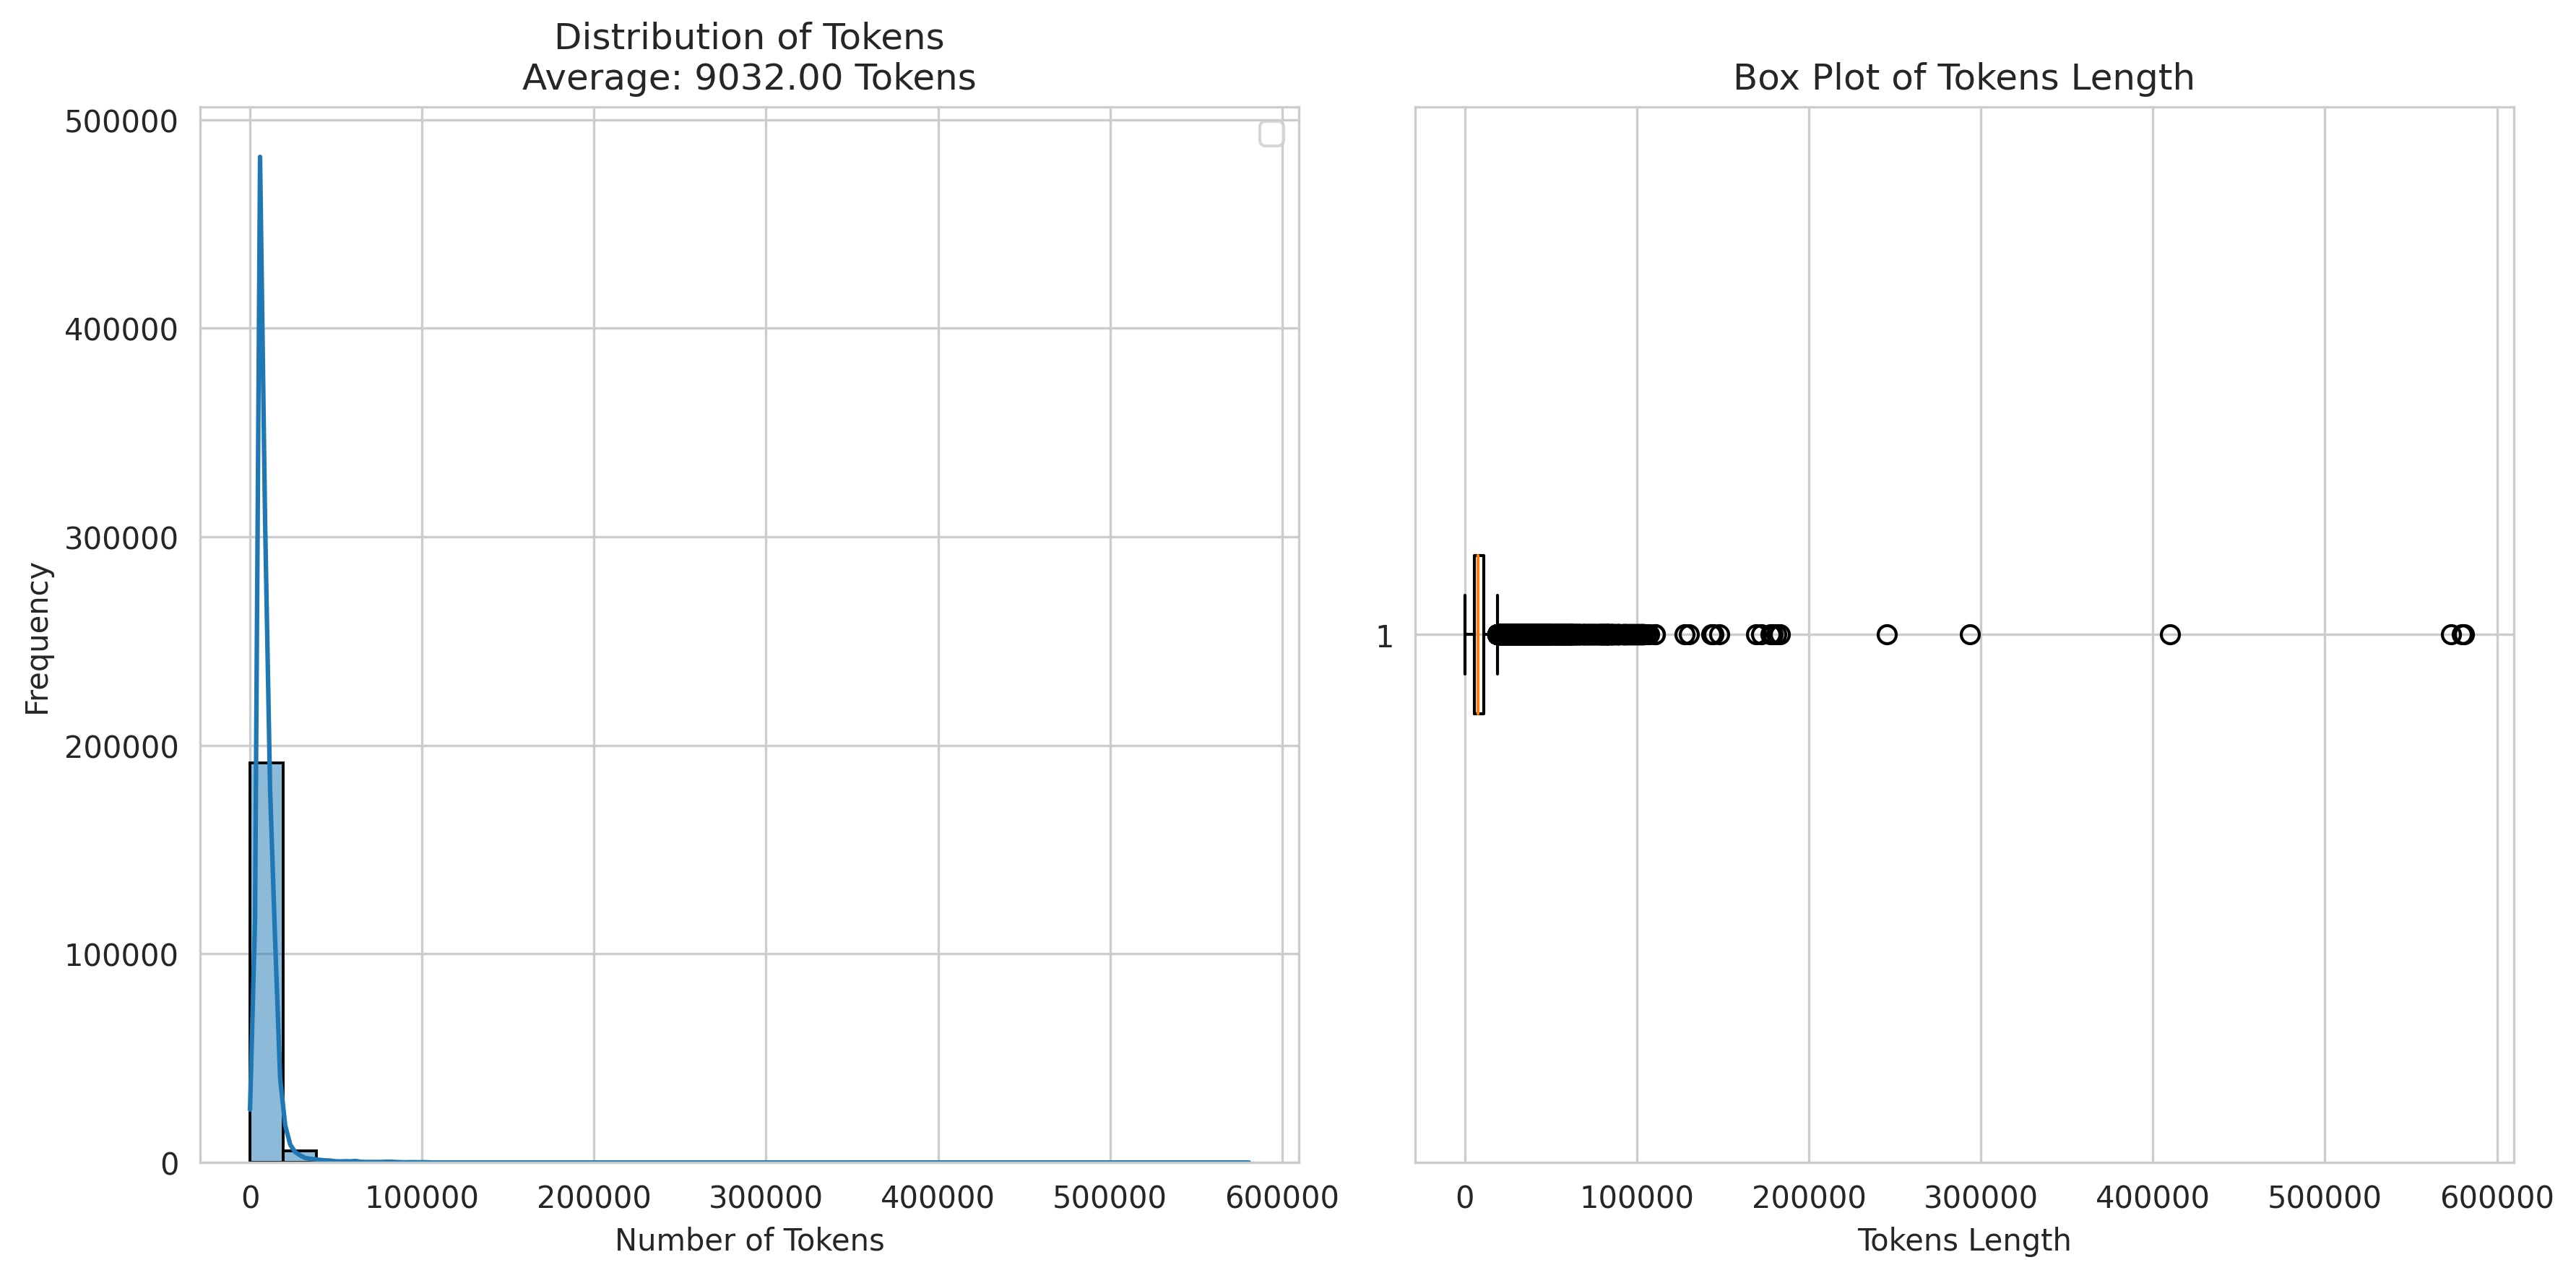

In [4]:
# Calculate the number of tokens in each record
df_news['num_tokens'] = df_news['text'].apply(lambda x: len(x))

# Calculate the average number of tokens
avg_tokens = round(df_news['num_tokens'].mean())

# Plot the distribution using histograms and a line for average number of tokens
plt.figure(figsize=(12, 6), dpi=300)

# Plot the histogram
plt.subplot(121)
sns.histplot(df_news['num_tokens'], bins=30, kde=True, edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title(f'Distribution of Tokens\nAverage: {avg_tokens:.2f} Tokens')
plt.legend()

# Plot the box plot to visualize outliers
plt.subplot(122)
plt.boxplot(df_news['num_tokens'], vert=False)
plt.xlabel('Tokens Length')
plt.title('Box Plot of Tokens Length')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [5]:
# Check the summary statistics for the number of tokens in text
print(df_news['num_tokens'].describe())

count    198735.000000
mean       9032.054671
std        7136.905961
min          18.000000
25%        5525.000000
50%        7566.000000
75%       10948.000000
max      580772.000000
Name: num_tokens, dtype: float64


It can be noted that minimum tokens are 18 which might not give any useful insight to the project. Let's bucktize the proportion of tokens to see if we can discard some articles.

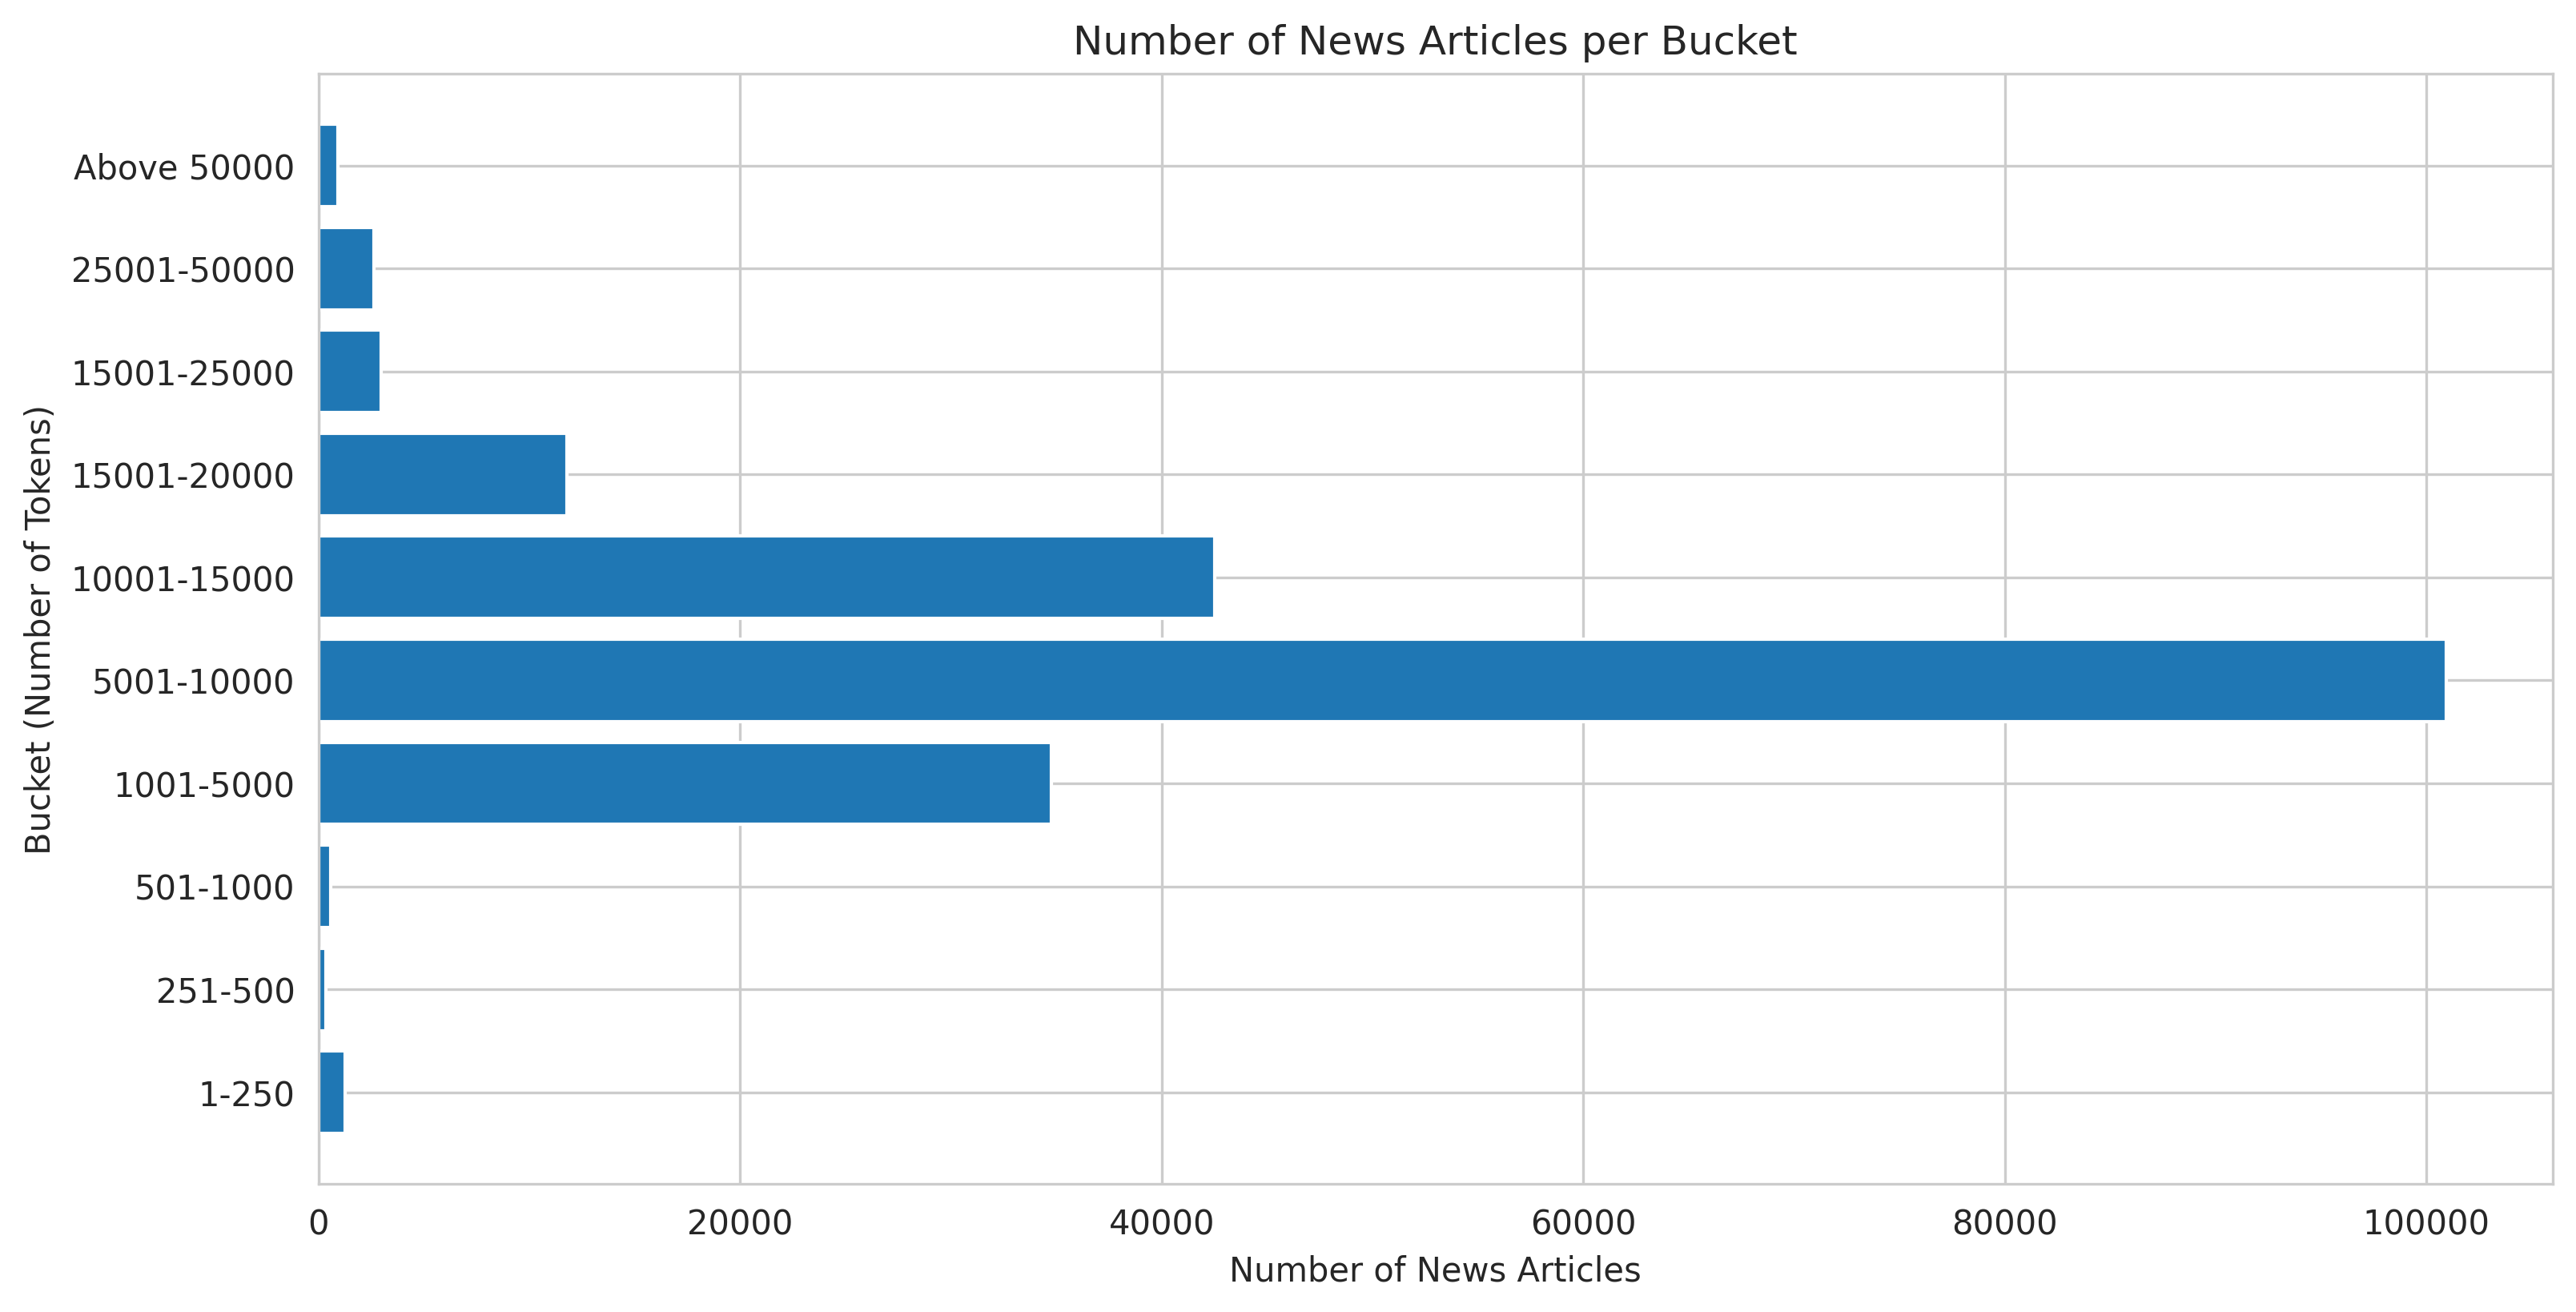

Bucket  Number of Articles
0        1-250                1273
1      251-500                 367
2     501-1000                 581
3    1001-5000               34764
4   5001-10000              100949
5  10001-15000               42518
6  15001-20000               11785
7  15001-25000                2977
8  25001-50000                2616
9  Above 50000                 905

In [6]:
# Define the bucket ranges
buckets = [1, 250, 500, 1000, 5000, 10000, 15000, 20000, 25000, 50000, float('inf')]

# Define the labels for the buckets
labels = ['1-250', '251-500', '501-1000', '1001-5000', '5001-10000', '10001-15000',  '15001-20000', '15001-25000', '25001-50000', 'Above 50000']

# Create a new column with the bucket labels
df_news['token_bucket'] = pd.cut(df_news['num_tokens'], bins=buckets, labels=labels, right=False)

# Count the number of articles in each bucket
bucket_counts = df_news['token_bucket'].value_counts().sort_index()

# Create a DataFrame to display the buckets and the number of articles
bucket_table = pd.DataFrame({'Bucket': bucket_counts.index, 'Number of Articles': bucket_counts.values})

plt.figure(figsize=(12, 6), dpi=300)  # Set the DPI value to 300

# Plot the bucket table
plt.barh(bucket_table['Bucket'], bucket_table['Number of Articles'])

# Add labels and title
plt.xlabel('Number of News Articles')
plt.ylabel('Bucket (Number of Tokens)')
plt.title('Number of News Articles per Bucket')

# Rotate the x-axis labels for better visibility
plt.xticks()

# Display the plot
plt.show()

bucket_table

 ~96% of the articles have tokens length range between 1000 to 20000. Thus, I will discard anything outside this range to remove outliers from dataset.

In [7]:
# Remove records where num_tokens is > 1000 and <= 20000
df_news = df_news[(df_news['num_tokens'] > 1000) & (df_news['num_tokens'] <= 20000)]

# Check the shape of dataset
df_news.shape


(190017, 9)

Number of articles reduced by ~8K in this step.

Let's do topic modelling now to understand top topics which can further help to make a dictionary of keywords to discard irrelevant news articles.

#### c) Topic Modelling

I. Using Word2Vec

In [8]:
def token_to_vector(corpus, model):
    """
    Generate vectors for a list of documents using a Word Embedding

    Args:
        corpus: List of documents
        model: Gensim's Word Embedding model

    Returns:
        Document vectors
    """
    # Initialize an empty list to store the document vectors
    features = [] 
    
    # Iterate over each document in the corpus
    for c in tqdm(corpus):
        # Initialize an empty list to store the token vectors for the document
        vectors = []  
        
        # Iterate over each token in the document
        for token in c: 
            # Check if the token is present in the Word Embedding model
            if token in model.wv:  
                try:
                    # Retrieve the vector representation for the token and add it to the list
                    vectors.append(model.wv[token])  
                except KeyError:
                    continue
                    
        # Check if any vectors were collected for the document
        if vectors:
            # Convert the list of token vectors to a NumPy array
            vectors = np.asarray(vectors)
            
            # Calculate the average vector representation for the document
            avg_vec = vectors.mean(axis=0) 
            
            # Add the average vector to the list of document vectors
            features.append(avg_vec)  
        else:
            # If no vectors are available for the document, append a zero vector
            features.append(np.zeros(model.vector_size)) 
            
    # Convert the list of document vectors to a NumPy array and return it
    return np.array(features)  


In [9]:
def featurize_text(df, column="lemmatized_text", method="cv", sparse=False):
    """
    Featurize the text using various word embedding methods
    """
    # Initialize the model based on the selected method
    if method == "cv":
        model = CountVectorizer()
    elif method == "tfidf-1gram":
        model = TfidfVectorizer(ngram_range=(1, 1), min_df=10)
    elif method == "tfidf-2gram":
        model = TfidfVectorizer(ngram_range=(1, 2), min_df=10)
    elif method == "word2vec":
        
        # Perform Word2Vec embedding
        tokens = df[column].apply(lambda x: x.split())
        model = Word2Vec(sentences=tokens, vector_size=100, workers=12, seed=SEED)
        X = token_to_vector(tokens, model)  # Assuming token_to_vector is a custom function
        X = pd.DataFrame(data=X, columns=[f"f{i+1}" for i in range(X.shape[1])])
    else:
        raise ValueError("Choose the value of the 'method' argument from 'cv', 'tfidf-1gram', 'tfidf-2gram', or 'word2vec'")
    
    # If the method is not Word2Vec, perform CountVectorizer or TF-IDF transformation
    if method != "word2vec":
        X = model.fit_transform(df[column])
        
        if sparse:
            return X, model  # Return sparse matrix and the model if sparse=True
        
        X = pd.DataFrame(X.toarray(), columns=model.get_feature_names_out())
    
    # Concatenate the featurized text with other features, if any
    X = pd.concat([X], axis=1)
    
    # Perform standard scaling on the features
    scaler = StandardScaler()
    X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)
    
    return X, model


In [10]:
# Implement Word2Vec Model
X, w2v_model = featurize_text(df_news, method="word2vec")

  0%|          | 0/190017 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

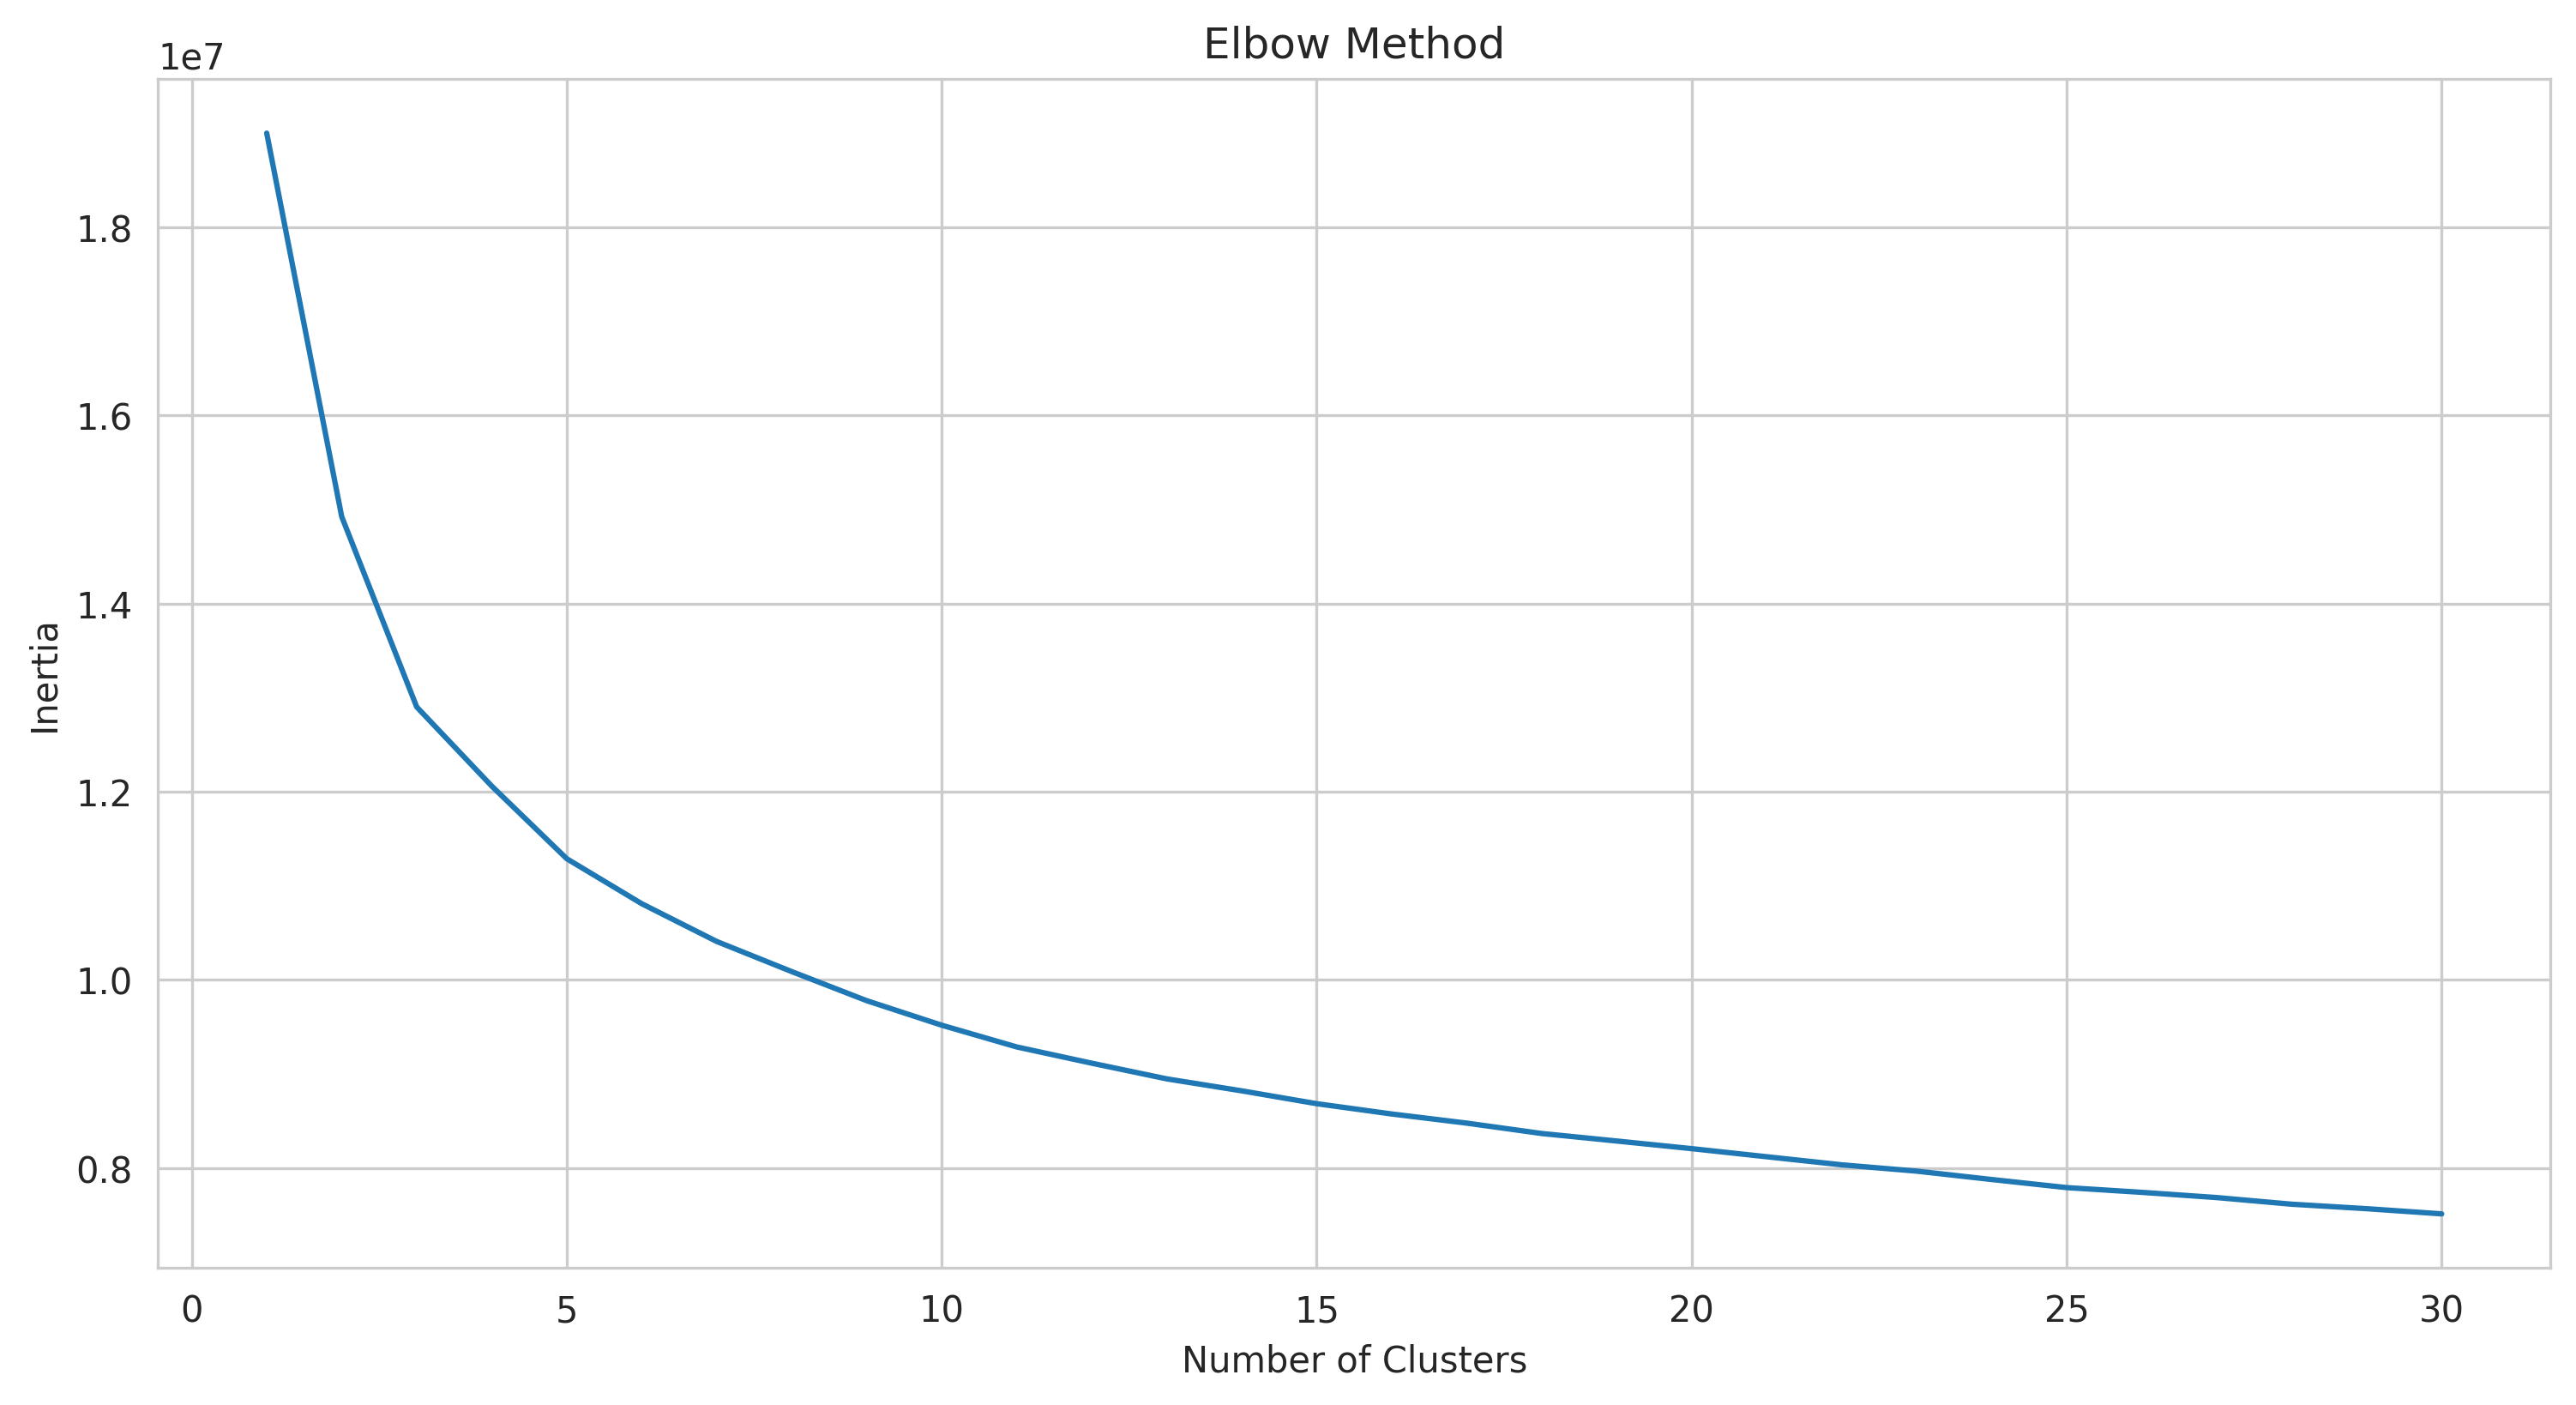

In [11]:
# Use elbow method to determine optimal number of clusters
# List to store the within-cluster sum of squares
wcss = []  

# Perform K-means clustering for different numbers of clusters
for i in tqdm(range(1, 31)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=400, n_init=10, random_state=SEED)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
# Plotting the results onto a line graph to observe 'The elbow'
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(range(1, 31), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia') 
plt.show()

Elbow method is not indicating the optimal number of clusters, except 3 clusters which does not make sense for long news articles. Thus, I will take number of clusters as 25 for further processing.

In [12]:
# Create a KMeans object with the specified number of clusters (25) and random state
kmeans = KMeans(n_clusters=25, random_state=SEED)

# Fit the K-means model to the data X
kmeans.fit(X)

# Retrieve the cluster labels assigned to each sample and increment them by 1
# The labels range from 0 to n_clusters-1, so adding 1 makes them range from 1 to n_clusters
labels = kmeans.labels_ + 1

# Assign the cluster labels to a new column "cluster" in the DataFrame df_news
df_news["cluster"] = labels

# Retrieve the coordinates of the cluster centroids
centroids = kmeans.cluster_centers_


print("Most representative terms per cluster (based on centroids):\n")
for i in range(25):
    # Initialize an empty string to store the tokens per cluster
    tokens_per_cluster = ""
    
    # Retrieve the most similar terms to the centroid of the current cluster using the Word2Vec model
    # The positive parameter takes the centroid as a positive example for similarity comparison
    # We retrieve the top 10 most similar terms    
    most_representative = w2v_model.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=10)

    
    for t in most_representative:
        # Concatenate the most similar terms to the tokens_per_cluster string
        tokens_per_cluster += f"{t[0]} "

    # Print the cluster number and the corresponding most similar terms   
    print(f"Cluster {i + 1}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):

Cluster 1: msk videahealth anumana oncologist nafld stbi bcbsri dedalus clinical techcyte 
Cluster 2: radio wpvm donate listen wxpr kcur npr contests volunteer kpr 
Cluster 3: subscribe advertisement sign login news newsletters epaper newsletter submit log 
Cluster 4: market global size forecast trends segmentation outlook scope analysis growth 
Cluster 5: usdx nbai rogin trc usdk hbar cartesi lisk roobee ckb 
Cluster 6: pinpointed lungs researchers mosquitoes infants bacteria kidneys tumours parasites rats 
Cluster 7: chatgpt anyway apparently though presumably actually perhaps even saying probably 
Cluster 8: cision unications ment telecoms retail lifestyle businessall multimedia services telecomm 
Cluster 9: market global size segmentation trends analysis scope forecast outlook regions 
Cluster 10: altaml exiger ipwe symphonyai cognite wovenware octo ensodata leader aqemia 
Cluster 11: prank haunting bloody scream nasty aw

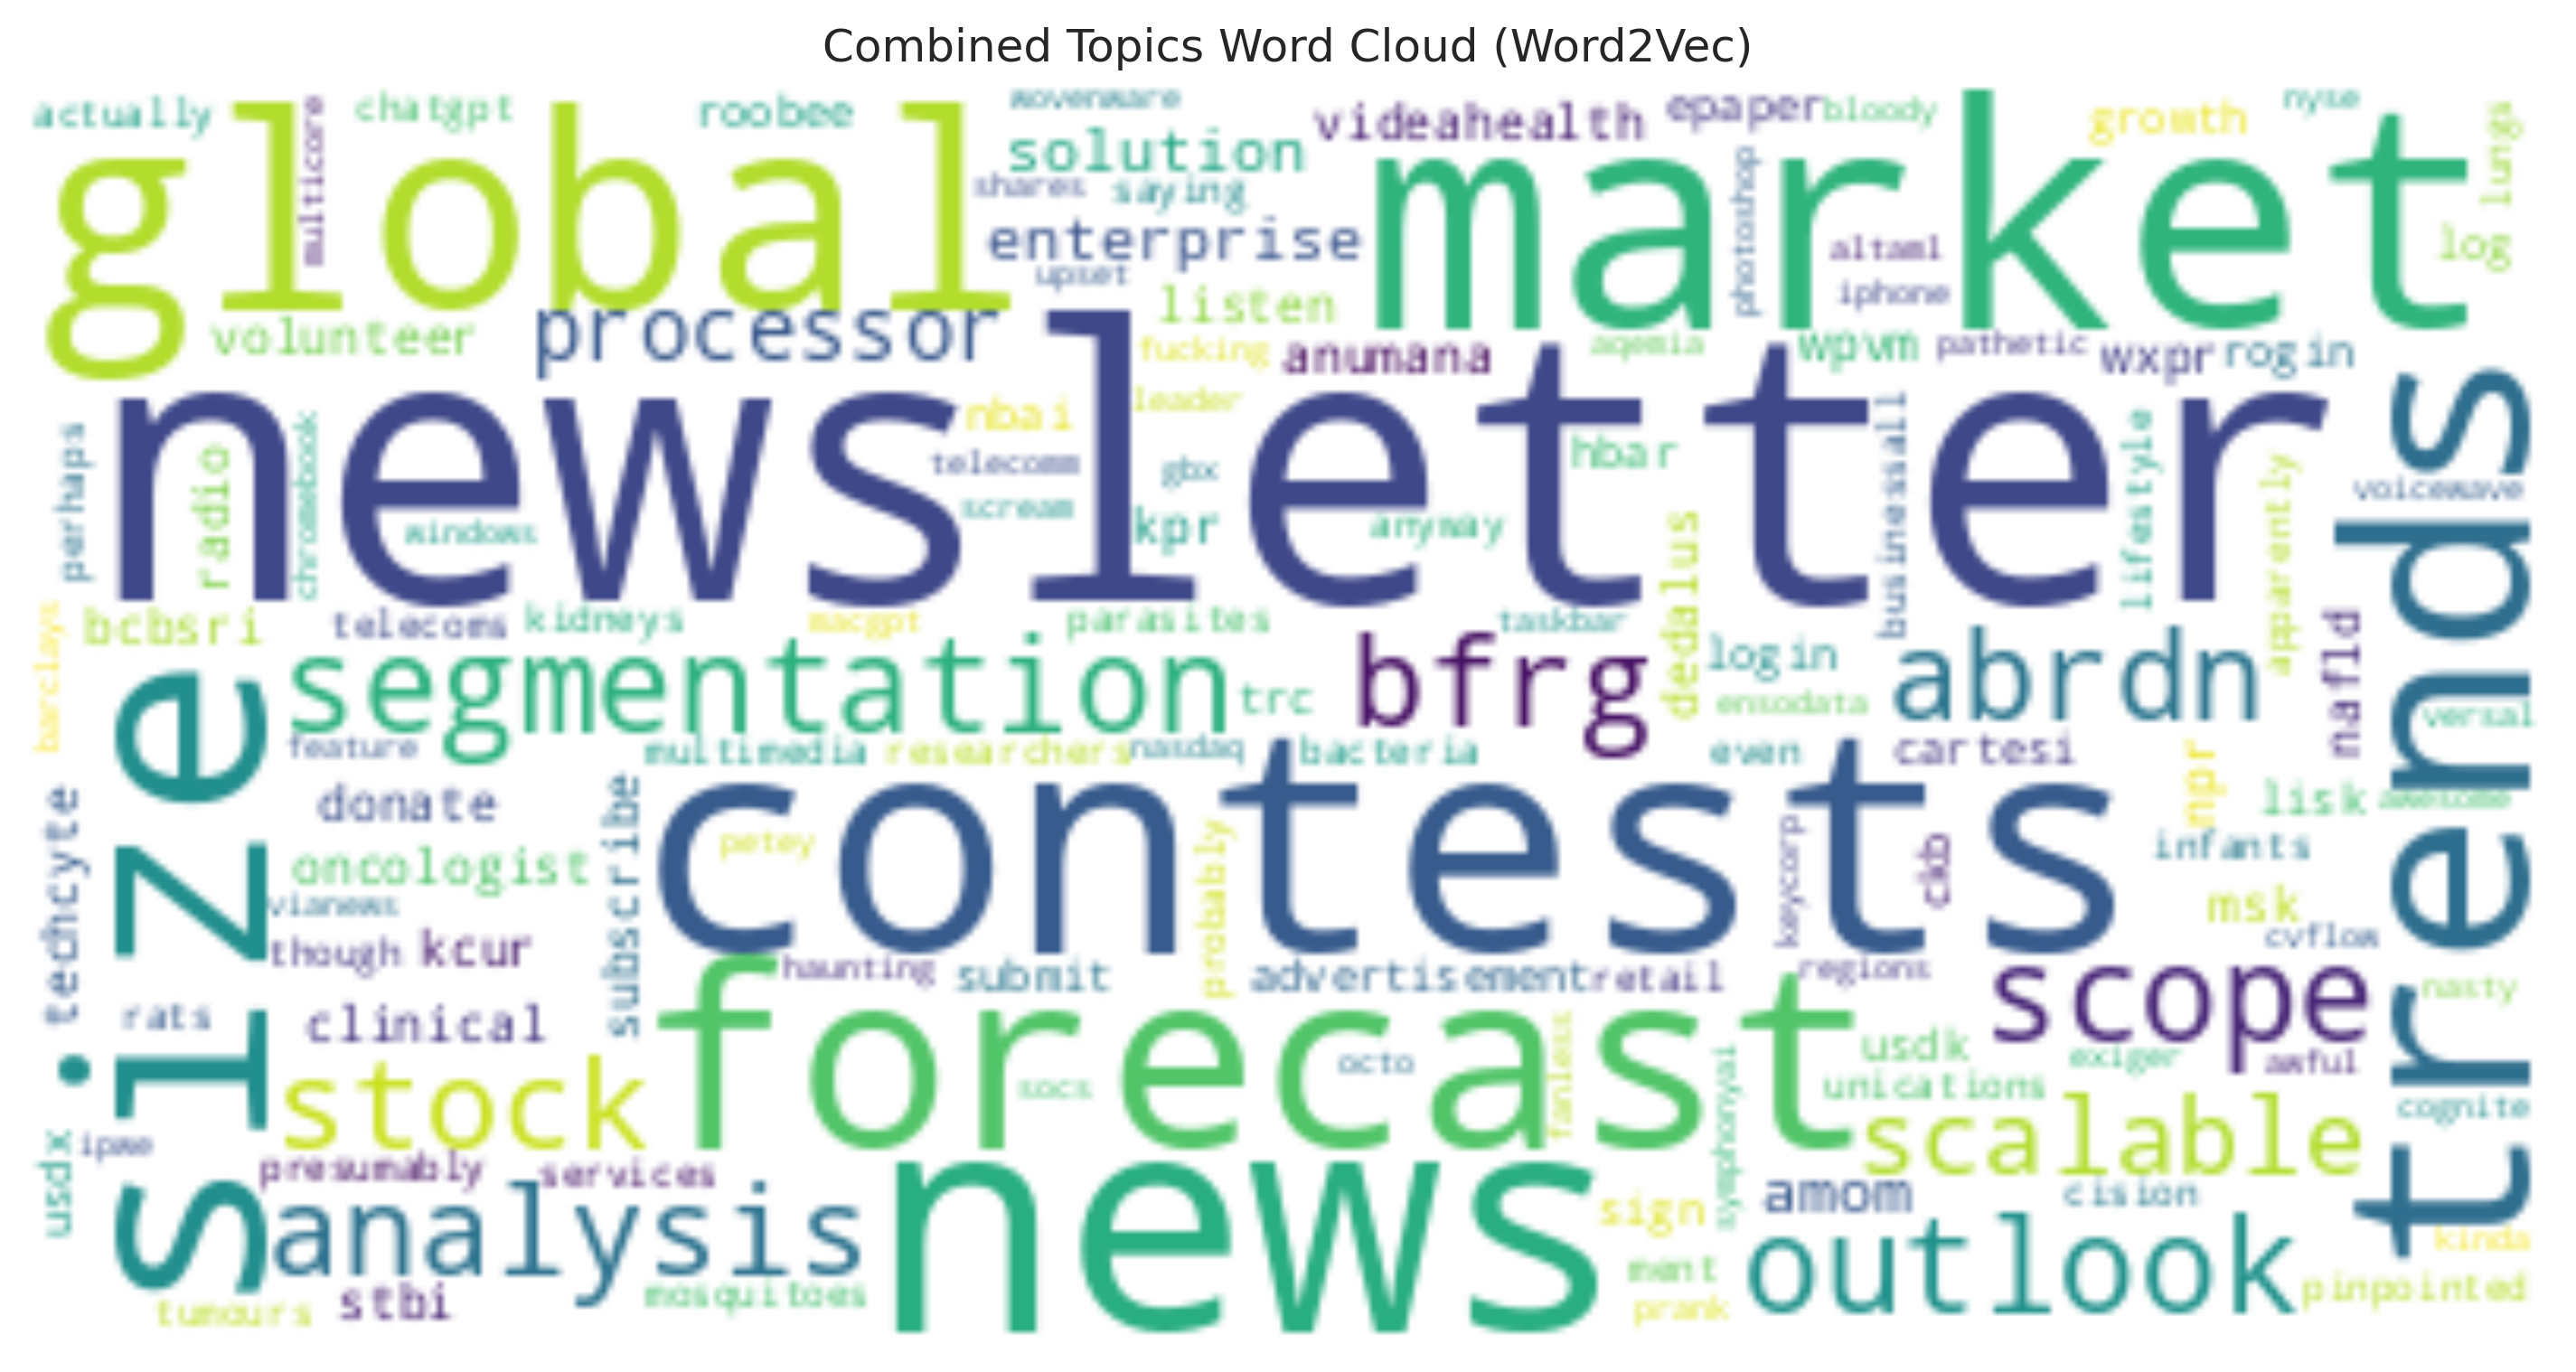

In [13]:
tokens_per_cluster = ""

for i in range(25):
    most_representative = w2v_model.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=10)

    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "

# Create a WordCloud object
wordcloud = WordCloud(background_color='white').generate(tokens_per_cluster)

# Create a figure and set the DPI
fig = plt.figure(figsize=(12, 9), dpi=300)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Combined Topics Word Cloud (Word2Vec)')

# Show the plot with adjusted DPI
fig.set_dpi(300)
plt.show()



WordCloud does indicate some keywords, however it is difficult to find the more words related to AI. Thus, I will now use Bertopic to get better idea of topics in news articles.

II. BERTopic

In [14]:
# Get the cleaned tokens from the DataFrame
cleaned_tokens = df_news['lemmatized_text'].tolist()

# Apply BERTopic to the cleaned tokens
model = BERTopic()
topics, _ = model.fit_transform(cleaned_tokens)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [15]:
# Retrieve the top topics and their associated documents
top_topics = model.get_topic_freq().head(25)  
top_topic_ids = top_topics['Topic']

for topic_id in top_topic_ids:
    # Get keywords associated with the current topic
    keywords = model.get_topic(topic_id)
    
    # Retrieve assigned topics for documents
    assigned_topics = topics
    
    # Find representative documents for the current topic
    representative_documents = [i for i, t in enumerate(assigned_topics) if t == topic_id]
    
    # Print the topic ID and its associated keywords
    print(f"Topic {topic_id}: {', '.join([word[0] for word in keywords])}")
    print()


Topic -1: us, policy, share, india, google, artificial, overview, rss, may, intelligence

Topic 0: corporation, players, market, vkontakte, analysis, growth, key, size, forecast, trends

Topic 1: ment, cision, entertain, overviewview, journalists, telecomm, environ, gdpr, inquiries, unications

Topic 2: machine, learning, bigml, size, market, packard, hewlett, catalog, players, service

Topic 3: und, zu, hoc, die, sie, auf, von, nachrichten, taufrufe, orderbuch

Topic 4: chinese, china, beijing, shanghai, sensetime, moviebook, chaillan, military, communist, hhm

Topic 5: wfmz, berks, lehigh, allentown, wdpn, freddy, matchups, corridor, valley, pa

Topic 6: brandvoice, richest, paid, forbes, program, cards, suvs, tableau, billionaires, refinance

Topic 7: virus, coronavirus, wuhan, pneumonia, outbreak, outbreaks, covid, bluedot, symptoms, infected

Topic 8: channelwise, sql, virtualisation, consumables, elegant, desired, engineer, etl, comms, payroll

Topic 9: artificial, intelligence, 

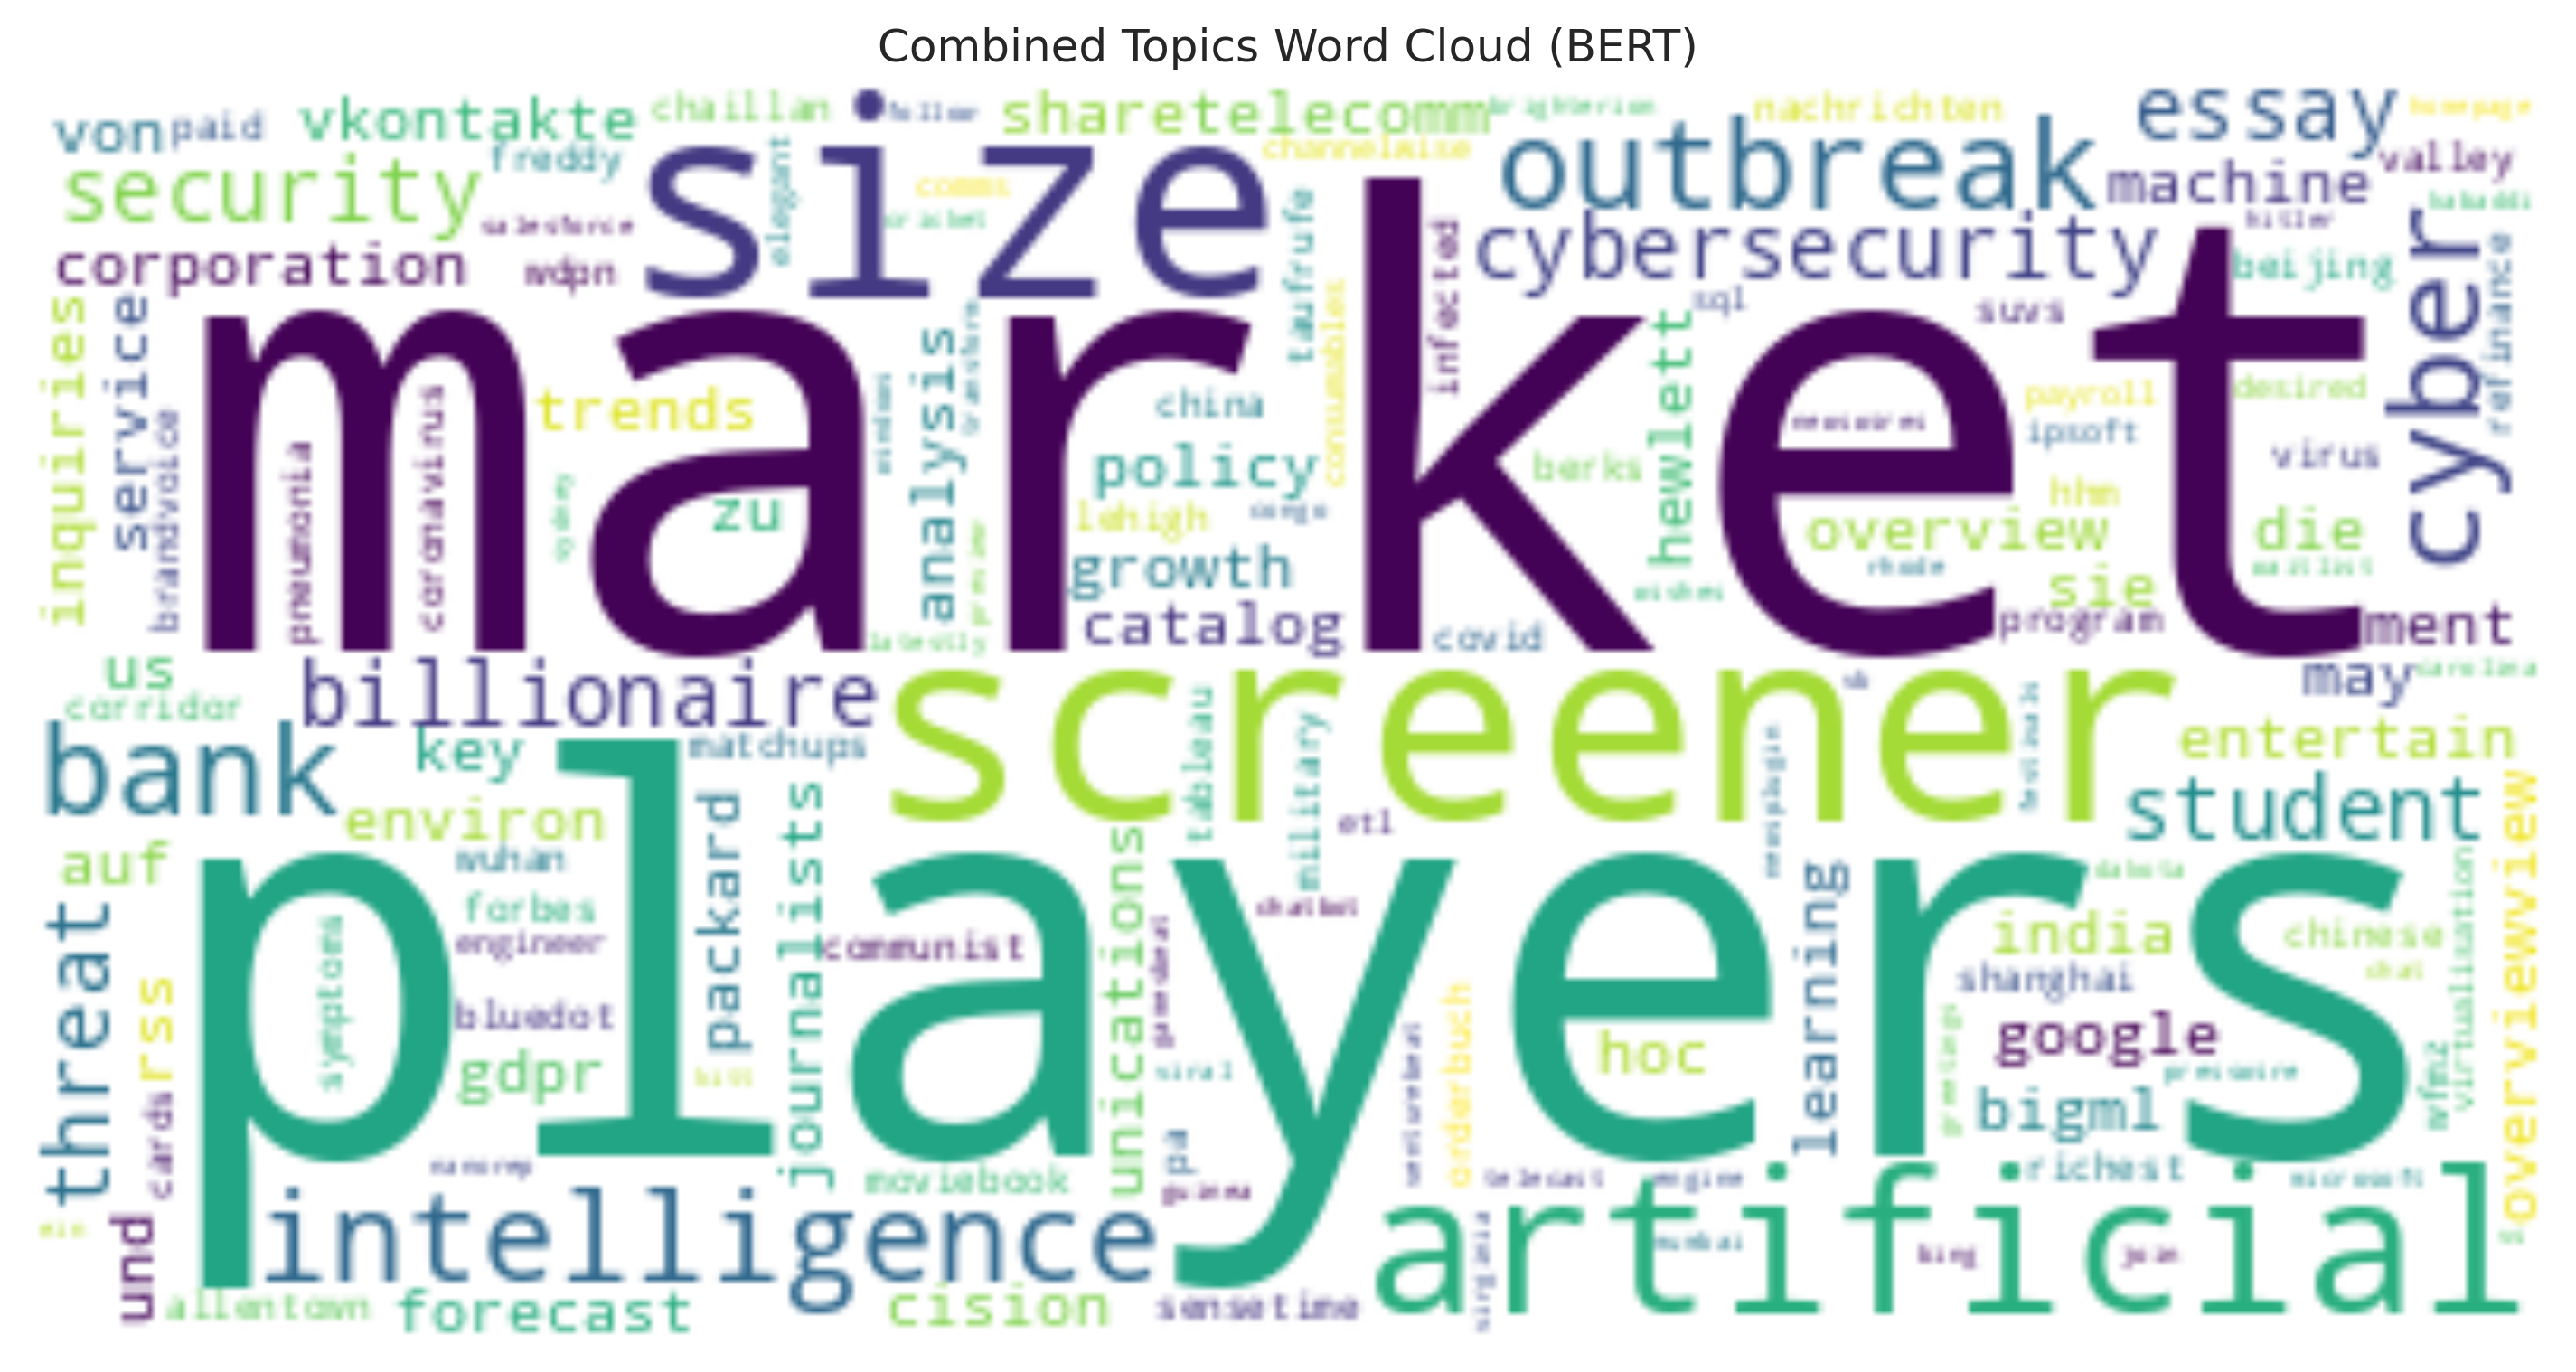

In [16]:
# Concatenate keywords from all topics
all_keywords = []
for topic_id in top_topic_ids:
    keywords = model.get_topic(topic_id)
    all_keywords.extend([word for word, _ in keywords])

# Generate word cloud
wordcloud = WordCloud(background_color='white').generate(' '.join(all_keywords))

# Create a figure and set the DPI
fig = plt.figure(figsize=(12, 9), dpi=300)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Combined Topics Word Cloud (BERT)')
plt.axis('off')

# Show the plot with adjusted DPI
fig.set_dpi(300)
plt.show()


Results of Bertopic were better on corpus. Hence, I would create a list of keywords based on results to discard irrelevant articles as follows:

In [8]:
# List of data science related words
keywords = ["artificial intelligence", "machine learning", "deep learning", "neural networks", "chatgpt"
            "data science", "predictive analytics", "automation", "ai impact", "ai in healthcare",
            "ai in manufacturing", "ai in finance", "ai jobs", "future of work", "bard",
            "ai transformation", "ai adoption", "openai", "conversational ai", "ai for image generation",
            "ai for speech recognition", "ai technologies", "ai in fintech", "ai in retail", "gpt"]

# Create a boolean mask
mask = df_news['text'].apply(lambda x: any(word in x.lower() for word in keywords))

# Filter the DataFrame using the mask
df_news_filtered = df_news[mask]

# Check the shape of resulting dataframe
df_news_filtered.shape


(160842, 9)

Great! ~30K news articles were discarded and articles more related to AI were selected in the final dataset for analysis with a total of ~160K news articles.

In [18]:
# Check the columns in df_news_filtered
df_news_filtered.columns

Index(['url', 'date', 'language', 'title', 'text', 'cleaned_text',
       'lemmatized_text', 'num_tokens', 'token_bucket', 'cluster'],
      dtype='object')

In [19]:
# Drop irrelevant columns
df_news_filtered = df_news_filtered.drop("cluster", axis=1).reset_index(drop=True)


In [20]:
# Display a few records
df_news_filtered.head(3)

url        date language   
0  http://en.people.cn/n3/2021/0318/c90000-983012...  2021-03-18       en  \
1                   http://www.dataweek.co.za/12835r  2021-03-26       en   
2  http://www.homeoffice.consumerelectronicsnet.c...  2021-03-10       en   

                                               title   
0  Artificial intelligence improves parking effic...  \
1  Forget ML, AI and Industry 4.0 – obsolescence ...   
2  Strategy Analytics: 71% of Smartphones Sold Gl...   

                                                text   
0  \n\nArtificial intelligence improves parking e...  \
1  \n\nForget ML, AI and Industry 4.0 – obsolesce...   
2  \n\nStrategy Analytics: 71% of Smartphones Sol...   

                                        cleaned_text   
0  artificial intelligence improves parking effic...  \
1  forget ml ai industry obsolescence focus febru...   
2  strategy analytics smartphones sold globally a...   

                                     lemmatized_text  num_tokens token_bucket  
0  artificial intelligence improves parking effic...        5752   5001-10000  
1  forget ml ai industry obsolescence focus febru...       13520  10001-15000  
2  strategy analytics smartphones sold globally a...        9490   5001-10000

In [9]:
# Save DataFrame as Parquet
df_news_filtered.to_parquet('processed_news_articles.parquet', engine='pyarrow')